# Mapping barcodes and promoters

© 2022 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

Import packages and set plotting style.

In [1]:
using wgregseq, CSV, DataFrames, Glob, BioSequences, CairoMakie, Statistics, StatsBase

# Set plotting style
wgregseq.plotting_style.default_makie!()

Import sequences from twist library.

In [2]:
# Import table with custom function for correct column types
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")

# Take promoter sequence from oligo
promoter_seqs = [seq[27:196] for seq in df_seqs.sequence]

# Add promoter sequence to table
insertcols!(df_seqs, 4, :promoter_seq => [x[27:186] for x in df_seqs.sequence])

first(df_seqs, 5)

,genes,sequence
,Array…,LongSequ…
1,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
2,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGTCTTTTTTTGTGATCACTCCGGCTATATTCGATCTATTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCGTCACGACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
3,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGCCTGTTTGTGTGATCACTACGGCGTTTTTCAATCTTTATACTTGTATGGTAGTCTCTCAGTTGCGTAGATTTGCTGCATCACGACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
4,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTGTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGCCTTTTCTCGAGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTGAGTTGTGTAGTTTTCATGCATCACAACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
5,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGCCTTCTTTTGTGATCACTCAGGCTCTTTTCGATCTTTCTACTAGTATGGTAATAGCTAATTTGCGTGGATTGCATGCATCACGACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC


In [3]:
df_wt = df_seqs[1:1501:119*1501, :]

,genes,sequence
,Array…,LongSequ…
1,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
2,"[""araA"", ""araB"", ""araD""]",ACCTGTAATTCCAAGCGTCTACTAGTTCCACATTGATTATTTGCACGGCGTCACACTTTGCTATGCCATAGCATTTTTATCCATAAGATTAGCGGATCCTACCTGACGCTTTTTATCGCAACTCTCTACTGTTTCTCCATACCCGTTTTTTTGGATGGAGTGAAACGATGGCGATTGCAATTGGCCGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
3,"[""znuB"", ""znuC""]",ACCTGTAATTCCAAGCGTCTACTAGTGTGTTGCACCTCCCCAGAGAGCGGCGGATAATGCTGCGAAAAGAAGCGTTTTTTTATGTAACATAATGCGACCAATAATCGTAATGAATATGAGAAGTGTGATATTATAACATTTCATGACTACTGCAAGACTAAAATTAACATGACAAGTCTGGTTTCCGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
4,"[""xylA"", ""xylB""]",ACCTGTAATTCCAAGCGTCTACTAGTCCAGTTTCATCATTCCATTTTATTTTGCGAGCGAGCGCACACTTGTGAATTATCTCAATAGCAGTGTGAAATAACATAATTGAGCAACTGAAAGGGAGTGCCCAATATTACGACATCATCCATCACCCGCGGCATTACCTGATTATGGAGTTCAATATGCGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
5,"[""xylF"", ""xylG"", ""xylH"", ""xylR""]",ACCTGTAATTCCAAGCGTCTACTAGTAATTGCGCAACAAAAGTAAGATCTCGGTCATAAATCAAGAAATAAACCAAAAATCGTAATCGAAAGATAAAAATCTGTAATTGTTTTCCCCTGTTTAGTTGCTAAAAATTGGTTACGTTTATCGCGGTGATTGTTACTTATTAAAACTGTCCTCTAACTAGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
6,"[""dicC"", ""ydfW"", ""ydfX""]",ACCTGTAATTCCAAGCGTCTACTAGTGAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCTGGGCCCCCGGGATTCAGTGATTGAACGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
7,"[""hokD"", ""relB"", ""relE""]",ACCTGTAATTCCAAGCGTCTACTAGTTGGACTTAGCAATGGCTGCTCCTGGCACAAAGCGGACAGTGATCACCGTTCTTACGACTACTTTCTGACTTCCTTCGTGACTTGCCCTAAGCATGTTGTAGTGCGATACTTGTAATGACATTTGTAATTACAAGAGGTGTAAGACATGGGTAGCATTAACGGGCCCCCGGGATTCAGTGATTGAACGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
8,"[""ftsK""]",ACCTGTAATTCCAAGCGTCTACTAGTTTCTGGTATTCGTTGAGATTACTCTGAATCGTGGCGCACCGGATGTGTTTGAACAATTCAATACCGCTGTACAAAAACTTGAAGAAATTCAGGAGTGTCATTTAGTATCCGGTGATTTCGACTACCTGTTGAAAACACGCGTGCCGGATATGTCAGCCTAGGGCCCCCGGGATTCAGTGATTGAACGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
9,"[""ftsK""]",ACCTGTAATTCCAAGCGTCTACTAGTACACGGACATACGTTGTTATGGAAGAAGTCAAGCAGAGTAATCGTCTGGTTATTAAGACGCGCTAACACGGAACAGGTGCAAAATCGGCGTATTTTGATTACACTCCTGTTAATCCATACAGCAACAGTACTGGGGTAACCTGGTACTGTTGTCCGTTTTGGGCCCCCGGGATTCAGTGATTGAACGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC


Read in the mapped sequencing reads. Remove reads that could not be mapped to a certain promoter, and threshold promoter variants by number of unique barcodes identified.

In [4]:
df = DataFrame()
for (root, dirs, files) in walkdir("../../../data/barcodes/20220514_mapping/100_per_gene_filtered/")
    for file in files
        if split(file, '.')[end] == "txt"
            name = join(split(file, '_')[1:end-2], '_')
            if name != "*"
                _df = CSV.read(
                    joinpath(root, file),
                        DataFrame,
                        types=Dict(
                            "name" => String,
                        )
                    )
                append!(
                    df, 
                    _df
                )
            end
        end
    end
end

In [5]:
# Import data file
df = df[df.name .!= "*", :]

# Count unique barcodes per promoter variant
df_bc = combine(groupby(df, [:promoter, :name]), nrow)[:, [:nrow, :name, :promoter]]

# Filter at 10 barcodes per variant
insertcols!(df_bc, 1, :thresh => map(x -> x > 9, df_bc.nrow))
df_bc.name |> unique
CSV.write("../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", df)

"../../../data/barcodes/20220514_mapping/mapped_barcodes.csv"

Now we count how many promoter variants pass the threshold. There are some promoters which have different names, but the same sequences. That can happen when two promoters have the same transcription start site in Ecocyc. Hence, for these promoters we have twice the number of variants. We also plot GC content against number of identified variants, as we think there might be a correlation.

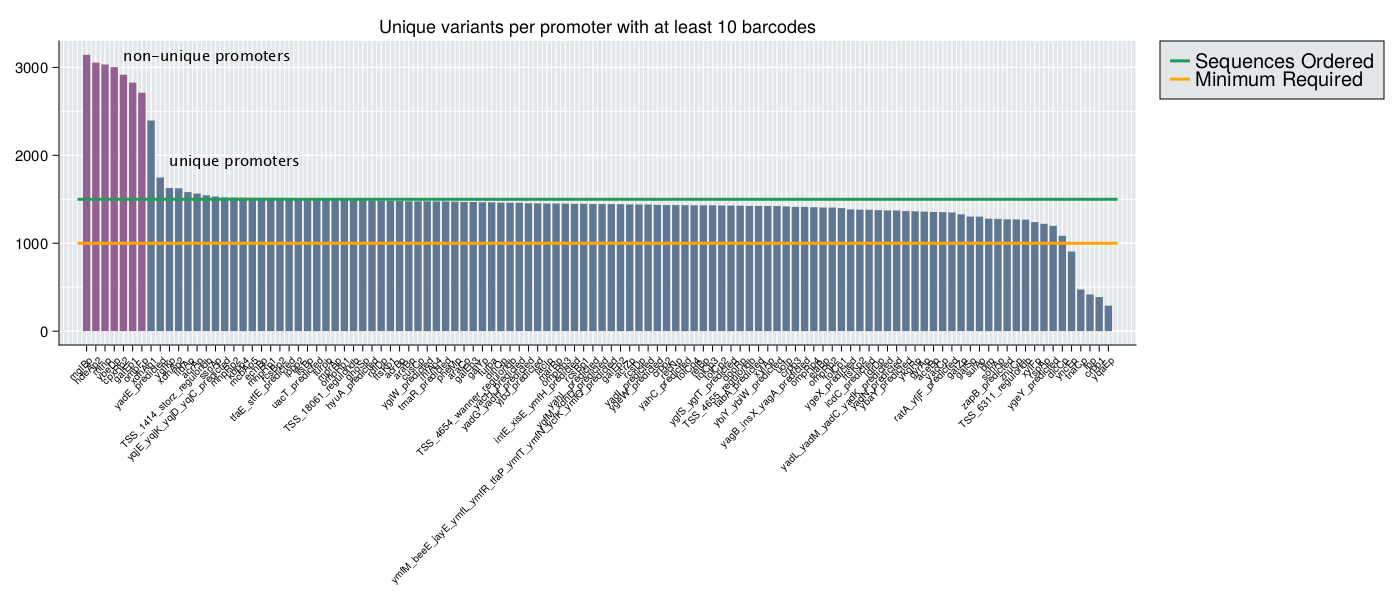

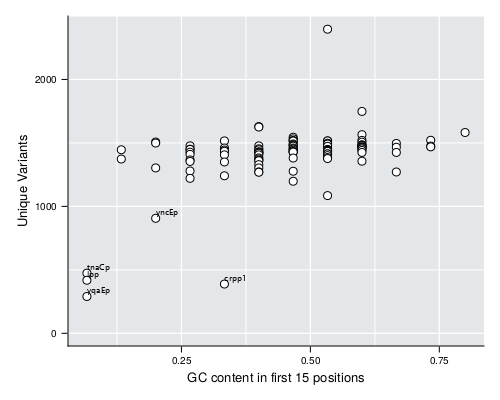

In [6]:
# Only keep variants that pass threshold
df_thresh = df_bc[df_bc.thresh .== 1, :]

# function to count unique entries
num_unique(x) = length(unique(x))

# Count unique variants per promoter
df_unique = combine(groupby(df_thresh, :name), :promoter => num_unique)

# Sort by number of variants
sort!(df_unique, :promoter_num_unique, rev=true)

# Remove empty ones
df_unique = df_unique[map(x -> x ∉  ["galEp", "ybeDp2"], df_unique.name), :]

# Initate figure
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])

# Color promotes that have two versions
color = map(x -> x in ["mglBp", "hdeAp2", "mtnp", "ybeDp", "cpxRp2", "galEp1", "ompFp"], df_unique.name)

# Plot counts
barplot!(
    ax, 
    1:nrow(df_unique), 
    df_unique.promoter_num_unique,
    color=color,
    colormap=[
        "#607794",
        "#946091"
        ]
)

# =Label plot
ax.xticks = (1:nrow(df_unique), df_unique.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 15
ax.title = "Unique variants per promoter with at least 10 barcodes"
ax.titlesize = 18
xlims!(-2, nrow(df_unique)+3)

maxi = lines!(
    ax, 
    [0, nrow(df_unique)+1], 
    [1500, 1500], 
    color="#239b56", 
    linewidth=3
    )

mini = lines!(
    ax, 
    [0, nrow(df_unique)+1], 
    [1000, 1000], 
    color="orange", 
    linewidth=3
    )

Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=20
)

text!(
    ax,
    "non-unique promoters", 
    position=(5, 3000), 
    textsize=15, 
    font="Lucida Sans"
    )

text!(
    ax, 
    "unique promoters", 
    position=(10, 1800), 
    textsize=15, 
    font="Lucida Sans"
    )

#save("../../../figures/unique_bc_prom.pdf", fig)
display(fig)

# Number of positions to check for gc content
gc_l = 15
insertcols!(
    df_unique, 
    2, 
    :wt_sequence => [df_wt[df_wt.promoter .== x, :promoter_seq][1] for x in df_unique.name]
    )

insertcols!(
    df_unique, 
    2, 
    :gc_content => [gc_content(x[1:gc_l]) for x in df_unique.wt_sequence]
    )

fig = Figure(resolution=(500, 400))
ax = Axis(fig[1, 1])

scatter!(
    ax, 
    df_unique.gc_content, 
    df_unique.promoter_num_unique, 
    markersize=8, 
    color="white", 
    strokewidth=1, 
    strokecolor="black"
    )

ax.ylabel = "Unique Variants"
ax.xlabel = "GC content in first $(gc_l) positions"
ylims!(ax, -100, 2500)

for i in 1:nrow(df_unique)
    if df_unique[i, :promoter_num_unique] < 1000
        text!(
            ax, 
            df_unique[i, :name], 
            position=(df_unique[i, :gc_content], df_unique[i, :promoter_num_unique]), 
            textsize=8, 
            font="Lucida Sans"
            )
    end
end
#save("../../../figures/gc_content_first_15.pdf", fig)
display(fig)



Let's look at the mutation rate in the promoters with low number of variants (and some controls with sufficient number of variants).

yqaEp: TATTTTCTAAATTAAGTAAACTCTAAACTAAAAATGCAACATATACCAGCCTCAGCAGCGTAAATGAGAGTAAAAGCGTAAGCTGAAACTGGCAGGCTCCGCTAAAATTACTACGCTTAAGAGATAAAATCTCTTTTTAAACAATGAGTAATTTTCTTAT


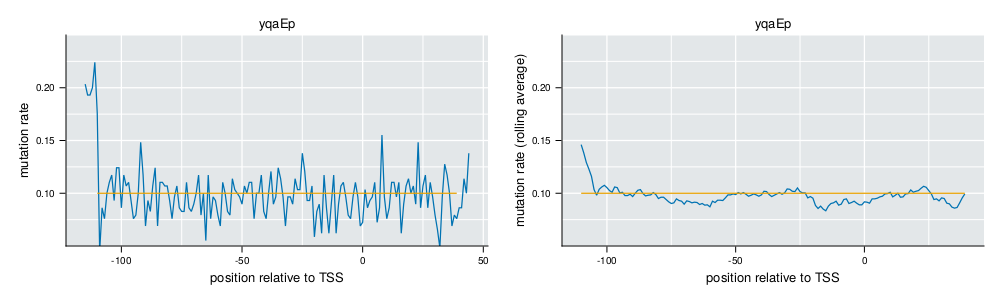

crpp1: AATTTTCCTGACAGAGTACGCGTACTAACCAAATCGCGCAACGGAAGGCGACCTGGGTCATGCTGAAGCGAGACACCAGGAGACACAAAGCGAAAGCTATGCTAAAACAGTCAGGATGCTACAGTAATACATTGATGTACTGCATGTATGCAAAGGACGT


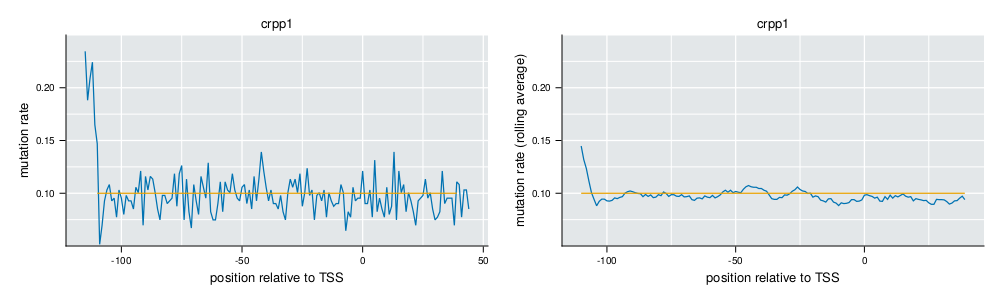

lpp: TTTTTTTATCTAAAACCCAGCGTTCGATGCTTCTTTGAGCGAACGATCAAAAATAAGTGCCTTCCCATCAAAAAAATATTCTCAACATAAAAAACTTTGTGTAATACTTGTAACGCTACATGGAGATTAACTCAATCTAGAGGGTATTAATAATGAAAGC


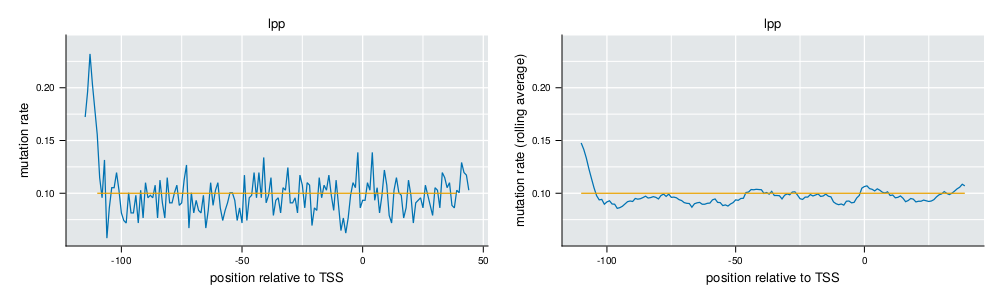

tnaCp: AATTTATAATCTTTAAAAAAAGCATTTAATATTGCTCCCCGAACGATTGTGATTCGATTCACATTTAAACAATTTCAGAATAGACAAAAACTCTGAGTGTAATAATGTAGCCTCGTGTCTTGCGAGGATAAGTGCATTATGAATATCTTACATATATGTG


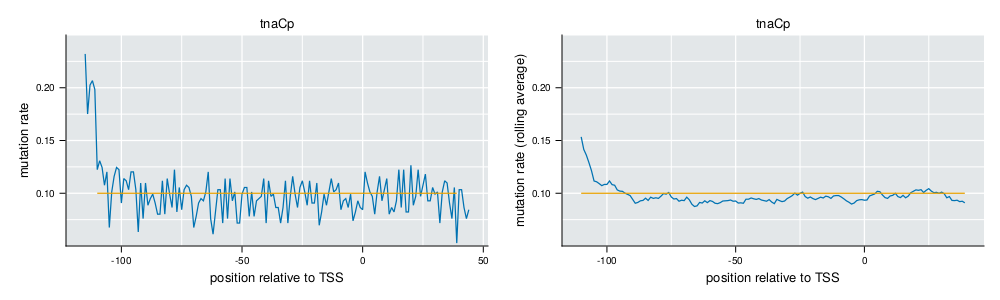

yncEp: TTGTAAATTTATGGAAAATGAAACGGCACAATACGTTAAGTAATTGAGAAAATTGTAGTCGTAACGGCAAGAAATGCTCCACATTTGAGAAAATAATGATTACCATTCCCATTTATAACAAGAGCGTAACGATGATTACGCTTAGCGAAGCATTGTGAAG


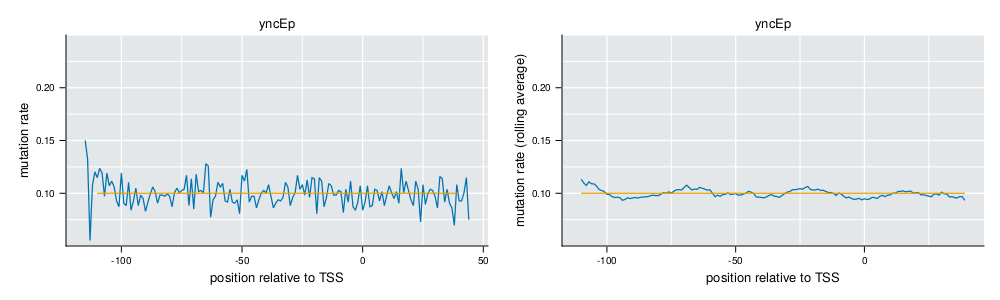

dicCp: GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT


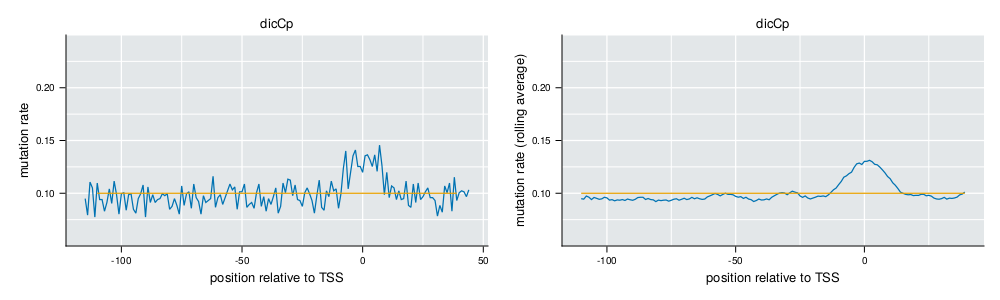

galEp1: CTGTTTTATAATCACTTAATCGCGCATAAAAAACGGCTAAATTCTTGTGTAAACGATTCCACTAATTTATTCCATGTCACACTTTTCGCATCTTTGTTATGCTATGGTTATTTCATACCATAAGCCTAATGGAGCGAATTATGAGAGTTCTGGTTACCGG


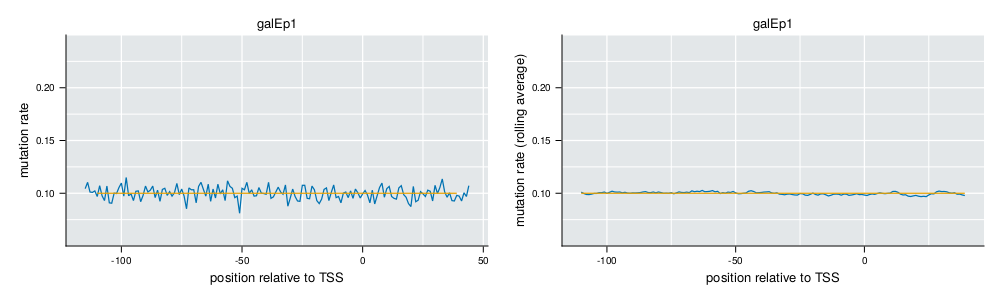

marRp: CTCTTTAGCTAGCCTTGCATCGCATTGAACAAAACTTGAACCGATTTAGCAAAACGTGGCATCGGTCAATTCATTCATTTGACTTATACTTGCCTGGGCAATATTATCCCCTGCAACTAATTACTTGCCAGGGCAACTAATGTGAAAAGTACCAGCGATC


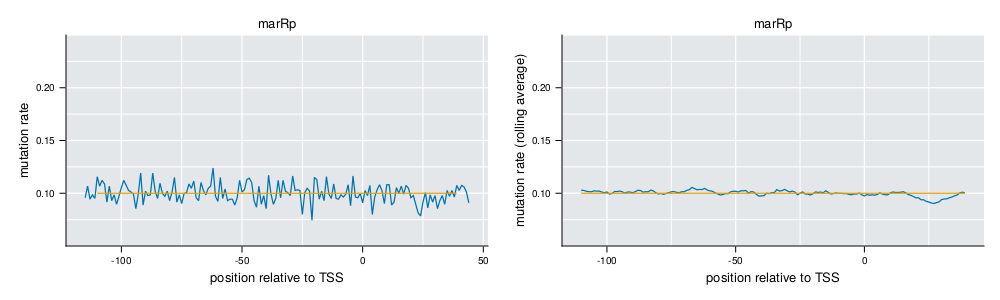

acrAp: CGAGGATGTGTTGGCGCGTTTCTTGCGCTTCTTGTTTGGTTTTTCGTGCCATATGTTCGTGAATTTACAGGCGTTAGATTTACATACATTTGTGAATGTATGTACCATAGCACGACGATAATATAAACGCAGCAATGGGTTTATTAACTTTTGACCATTG


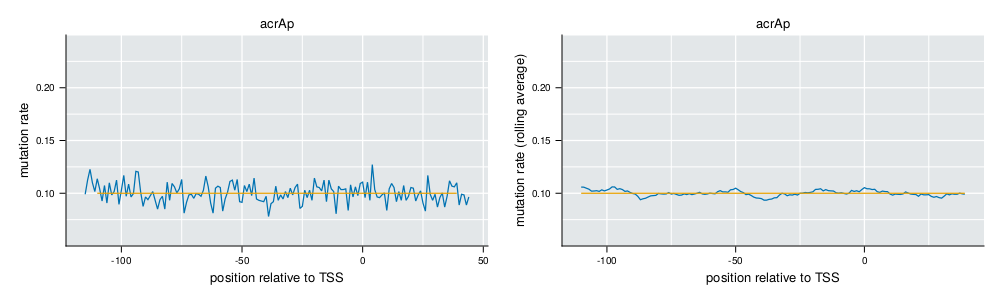

In [7]:
proms = ["yqaEp", "crpp1", "lpp", "tnaCp", "yncEp", "dicCp", "galEp1", "marRp", "acrAp"]
df_thresh.promoter = map(x -> LongDNA{4}(x), df_thresh.promoter)
for prom in proms
    seq = df_seqs[df_seqs.promoter .== prom, :sequence][1][27:186]
    println(prom, ": ", seq)
    
    pfm = df_thresh[df_thresh.name .== prom, :promoter] |> PFM
    mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_thresh[df_thresh.name .== prom, :promoter]) |> vec
    mut_rate_av = [mean(mut_rate[i-5:i+5]) for i in 6:length(mut_rate)-5]
    fig = Figure(resolution=(1000, 300))
    ax = Axis(fig[1, 1])
    lines!(ax, collect(-115:1:44), mut_rate)

    ax.title = prom
    ax.xlabel = "position relative to TSS"
    ax.ylabel = "mutation rate"
    lines!(ax, [-110, 39], [0.1, 0.1])
    ylims!(ax, 0.05, 0.25)

    ax2 = Axis(fig[1, 2])
    lines!(ax2, collect(-110:1:39), mut_rate_av)
    lines!(ax2, [-110, 39], [0.1, 0.1])
    ylims!(ax2, 0.05, 0.25)

    ax2.title = prom
    ax2.xlabel = "position relative to TSS"
    ax2.ylabel = "mutation rate (rolling average)"

    display(fig)
end


We see that promoters with low number of variants have an increased mutation rate in the beginning of the reads. This means, that sequences need to have a mutation there to in order to be sequenced. This issue could come from multiple sources. It could be synthesis issues by Twist, amplification issues in the cloning protocol, or issues in sequencing. I would guess that there might be issues with sequencing when the read starts with many As and Ts. Therefore, we will need to look at the sequencing quality and compare the quality for those promoters to others.

In addition, we find an increase in mutation rate around the transcription start site for the dicC promoter. Interestingly, this is where a transcription factor binds. The hypothesis is that the transcription factor binds to the plasmids during cloning, which leads to a fitness defect, unless the binding site is mutated, which leads to weaker binding of the transcription factor. 

### Downsampling of reads

Here we try to simulate a sequencing run with the same data, but a lower number of reads. How many variants would we still identify with 1/2, 1/4 or 1/10 of the reads? Therefore, we bootstrap the dataset. In total we have about 280 million reads.

In [8]:
"""
From https://stackoverflow.com/questions/63405501/julia-fastest-way-to-count-number-of-unique-elements-in-a-sorted-array-possibly
"""
function nunique(a)
    last = first(a)
    n = 1
    for x in a
        if isless(last, x)
            n += 1
            last = x
        end
    end
    n
end

nunique

In [49]:
new_counts = 1/16

weights = Weights(df.counts)
resample = sample(1:nrow(df), weights, Int(floor(sum(df.counts)*new_counts))) |> sort
new_counts = countmap(resample)


df_resample = copy(df)
insertcols!(df_resample, 1 ,:re_count => 0)
for key in collect(keys(new_counts))
    df_resample[key, :re_count] = new_counts[key]
end
df_resample =  df_resample[df_resample.re_count .> 2, :]

,re_count,promoter
,Int64,String
1,74,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,69,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
3,62,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
4,72,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
5,68,GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGAGACTCTGAGTGGTCAGACGATAATGCACTCACCATAAATGTACAGCTAAATGTTTTCCCTCGATTTTATCACTGGATGGATTCCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG
6,49,GATGACGACAAAATCGTTCACCTTATGCCTGCCGTAAGAGTCTGTGAGTGGTCAGACGATAACGGACTCACCTTAAATCTGCAGCTTAAGAATTTCCCTGGATTTTATGACTGGATGGATTAGCCTGATCACCCGGTTAAGTTTTATTTTCACATACTTG
7,67,GATGACGAGAAACTCACTATTCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCTCCAAAAATGTGAAGTTCAATGATTTCTCTGGATTTTATGACTGGATCGTTTACCCTTATCACCCCGTTATGTTTGGTTTTTACATACTTG
8,52,GATGACCACAGACTCAGTCATCTCATGGCTGCCGTACGAGCCTGTGCGTGGTCAGACGATAACGAACTCACCATAAATGTGCAGTTTAAAGAATTCCCTGGATACTATGACTTGCTGGATTTCCCTGATCACCCGGCTACGTTTGTTTTTCACATAATTG
9,55,GATGACGACAAACTCATTCATCTCATGGCTGCCTGCCGACACTGTGAGTGGTCAGACGATAACGGCCTCGCCATAAATATGCACTTTCATCATTTCCCTGGATTTTATGACTGGATGGCTTACCCTGATCACCCGATTAAGCTTGTTTTTCAGACACTTG


In [50]:
# Count unique barcodes per promoter variant
df_bc_re = combine(groupby(df_resample, [:promoter, :name]), nrow)[:, [:nrow, :name, :promoter]]

# Filter at 10 barcodes per variant
insertcols!(df_bc_re, 1, :thresh => map(x -> x > 9, df_bc_re.nrow))

,thresh,nrow,name,promoter
,Bool,Int64,String,String
1,1,26,TSS_1414_storz_regulondb,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,1,32,TSS_1414_storz_regulondb,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
3,1,29,TSS_1414_storz_regulondb,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
4,1,19,TSS_1414_storz_regulondb,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
5,1,31,TSS_1414_storz_regulondb,GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGAGACTCTGAGTGGTCAGACGATAATGCACTCACCATAAATGTACAGCTAAATGTTTTCCCTCGATTTTATCACTGGATGGATTCCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG
6,1,31,TSS_1414_storz_regulondb,GATGACGACAAAATCGTTCACCTTATGCCTGCCGTAAGAGTCTGTGAGTGGTCAGACGATAACGGACTCACCTTAAATCTGCAGCTTAAGAATTTCCCTGGATTTTATGACTGGATGGATTAGCCTGATCACCCGGTTAAGTTTTATTTTCACATACTTG
7,1,39,TSS_1414_storz_regulondb,GATGACGAGAAACTCACTATTCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCTCCAAAAATGTGAAGTTCAATGATTTCTCTGGATTTTATGACTGGATCGTTTACCCTTATCACCCCGTTATGTTTGGTTTTTACATACTTG
8,1,28,TSS_1414_storz_regulondb,GATGACCACAGACTCAGTCATCTCATGGCTGCCGTACGAGCCTGTGCGTGGTCAGACGATAACGAACTCACCATAAATGTGCAGTTTAAAGAATTCCCTGGATACTATGACTTGCTGGATTTCCCTGATCACCCGGCTACGTTTGTTTTTCACATAATTG
9,1,40,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCTGCCGACACTGTGAGTGGTCAGACGATAACGGCCTCGCCATAAATATGCACTTTCATCATTTCCCTGGATTTTATGACTGGATGGCTTACCCTGATCACCCGATTAAGCTTGTTTTTCAGACACTTG


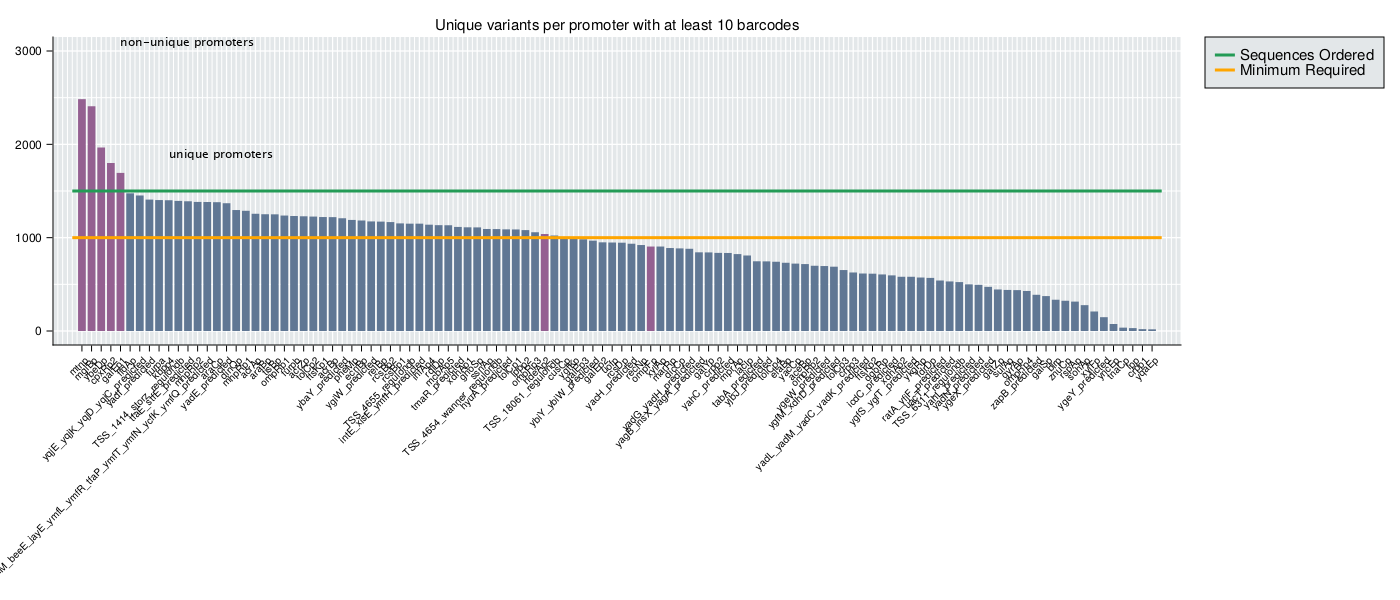

In [51]:
# Only keep variants that pass threshold
df_thresh_re = df_bc_re[df_bc_re.thresh .== 1, :]

# function to count unique entries
num_unique(x) = length(unique(x))

# Count unique variants per promoter
df_unique_re = combine(groupby(df_thresh_re, :name), :promoter => num_unique)

# Sort by number of variants
sort!(df_unique_re, :promoter_num_unique, rev=true)

# Remove empty ones
df_unique_re = df_unique_re[map(x -> x ∉  ["galEp", "ybeDp2"], df_unique_re.name), :]

# Initate figure
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])

# Color promotes that have two versions
color = map(x -> x in ["mglBp", "hdeAp2", "mtnp", "ybeDp", "cpxRp2", "galEp1", "ompFp"], df_unique_re.name)

# Plot counts
barplot!(
    ax, 
    1:nrow(df_unique_re), 
    df_unique_re.promoter_num_unique,
    color=color,
    colormap=[
        "#607794",
        "#946091"
        ]
)

# =Label plot
ax.xticks = (1:nrow(df_unique_re), df_unique_re.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
ax.title = "Unique variants per promoter with at least 10 barcodes"
ax.titlesize=15
xlims!(-2, nrow(df_unique_re)+3)

maxi = lines!(ax, [0, nrow(df_unique_re)+1], [1500, 1500], color="#239b56", linewidth=3)
mini = lines!(ax, [0, nrow(df_unique_re)+1], [1000, 1000], color="orange", linewidth=3)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)

text!(ax, "non-unique promoters", position=(5, 3000), textsize=12, font="Lucida Sans")
text!(ax, "unique promoters", position=(10, 1800), textsize=12, font="Lucida Sans")
#save("../../../figures/unique_bc_prom_0_1.pdf", fig)
display(fig)


In [9]:
prom = "dicCp"
seq = df_seqs[df_seqs.promoter .== prom, :sequence][1][27:186]

pfm = df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter] |> PFM
mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter]) |> vec

mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter]) |> vec
mut_rate_av = [mean(mut_rate[i-5:i+5]) for i in 6:length(mut_rate)-5]
fig = Figure(resolution=(1000, 300))
ax = Axis(fig[1, 1])
lines!(ax, collect(-115:1:44), mut_rate)
vlines!(ax, 107-116, color="grey", linestyle=:dash)
vlines!(ax, 125-116, color="grey", linestyle=:dash)

lines!(ax, [-115, 44], [0.1, 0.1], color="orange")

println("Possible dicA binding site: ", seq[107:125])

ax.title = prom
ax.xlabel = "position relative to TSS"
ax.ylabel = "mutation rate"

ax2 = Axis(fig[1, 2])
lines!(ax2, collect(-110:1:39), mut_rate_av)
ylims!(ax2, 0.05, 0.15)
vlines!(ax2, 107-116, color="grey", linestyle=:dash)
vlines!(ax2, 125-116, color="grey", linestyle=:dash)

lines!(ax2, [-110, 39], [0.1, 0.1], color="orange")

println("Possible dicA binding site: ", seq[107:125])

ax2.title = prom
ax2.xlabel = "position relative to TSS"
ax2.ylabel = "mutation rate (rolling average of 10bp)"

#save("../../../figures/dicCp_mutation_rate_oligos.pdf", fig)

display(fig)

LoadError: UndefVarError: df_barcodes_thresh_100 not defined

dicCp: GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT


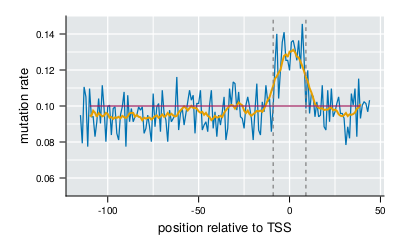

In [33]:
fig = Figure(resolution=(400, 250))

prom = "dicCp"
df_thresh.promoter = map(x -> LongDNA{4}(x), df_thresh.promoter)

seq = df_seqs[df_seqs.promoter .== prom, :sequence][1][27:186]
println(prom, ": ", seq)

pfm = df_thresh[df_thresh.name .== prom, :promoter] |> PFM
mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_thresh[df_thresh.name .== prom, :promoter]) |> vec
mut_rate_av = [mean(mut_rate[i-5:i+5]) for i in 6:length(mut_rate)-5]

ax = Axis(fig[1, 1])
lines!(ax, collect(-115:1:44), mut_rate)
lines!(ax, collect(-110:1:39), mut_rate_av, linewidth=2)

ax.xlabel = "position relative to TSS"
ax.ylabel = "mutation rate"
lines!(ax, [-110, 39], [0.1, 0.1], color=wgregseq.plotting_style.my_color_dict["purple1"])
ylims!(ax, 0.05, 0.15)

#ax2 = Axis(fig[1, 2])
#lines!(ax2, collect(-110:1:39), mut_rate_av)
#lines!(ax2, [-110, 39], [0.1, 0.1])
#ylims!(ax2, 0.05, 0.15)

#ax2.xlabel = "position relative to TSS"
#ax2.ylabel = "mutation rate \n(rolling average 11bp)"

#vlines!(ax2, 107-116, color="grey", linestyle=:dash)
#vlines!(ax2, 125-116, color="grey", linestyle=:dash)
vlines!(ax, 107-116, color="grey", linestyle=:dash)
vlines!(ax, 125-116, color="grey", linestyle=:dash)
display(fig)
save("../../../figures/dicCp_mutation_rate_oligos.pdf", fig)

In [28]:
"dicCp" in df_thresh.name

true

In [35]:
df_seqs

,genes,sequence
,Array…,LongSequ…
1,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
2,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGTCTTTTTTTGTGATCACTCCGGCTATATTCGATCTATTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCGTCACGACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
3,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGCCTGTTTGTGTGATCACTACGGCGTTTTTCAATCTTTATACTTGTATGGTAGTCTCTCAGTTGCGTAGATTTGCTGCATCACGACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
4,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTGTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGCCTTTTCTCGAGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTGAGTTGTGTAGTTTTCATGCATCACAACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
5,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGCCTTCTTTTGTGATCACTCAGGCTCTTTTCGATCTTTCTACTAGTATGGTAATAGCTAATTTGCGTGGATTGCATGCATCACGACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
6,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTGTTCATCTTTTGTCAACCATTCACAGCGCGACTCTACGCCTTTTTTTGTGATTACATCGGTTTTTTTCGAGCTTTTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACATGAGACGCAAGGAATCGGACATGCAGATCGTAATGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
7,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTTAGCTTTTGTCAACCATTCACAGCGCAACTATACGACTTTTTGTGTGATCACTCCGGCTTGTTTCGATCTTTATACTTGTAGGGTAGTCCATCAGTTGCGTAGATTACATGCTTCACGACATGCGATGCAAGGAATCGAACTTGAATATCGTAAAAGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
8,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCAGTCATAGTGCAAATATACTGCTTTTTTTGTGATCACTCCGGCTTTTTTCAATTCCTATACTTGTATGGTAGAAGCTCAGTTGCGCAGATTTCATGCATCGCTTCAAGCGATGCAAGGAATCGAACATGAAGATCGTAAGAGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
9,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTCTCATCTTTTGTCAACCATTAACAGCGCAAAGATCCGGCTTTTATTGTGATCGCTCCGACTTTTTTCGATCTTTATACTTGTATGGAAGTAGATCAGTCGCGTAGACTTCATGCATTAAGACAAGCGATGCAAGGAATCGAACATGAAGATCGGAAAGTGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC


In [37]:
df_thresh

,thresh,nrow,name,promoter
,Bool,Int64,String,LongSequ…
1,1,55,TSS_1414_storz_regulondb,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,1,84,TSS_1414_storz_regulondb,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
3,1,75,TSS_1414_storz_regulondb,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
4,1,52,TSS_1414_storz_regulondb,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
5,1,79,TSS_1414_storz_regulondb,GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGAGACTCTGAGTGGTCAGACGATAATGCACTCACCATAAATGTACAGCTAAATGTTTTCCCTCGATTTTATCACTGGATGGATTCCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG
6,1,61,TSS_1414_storz_regulondb,GATGACGACAAAATCGTTCACCTTATGCCTGCCGTAAGAGTCTGTGAGTGGTCAGACGATAACGGACTCACCTTAAATCTGCAGCTTAAGAATTTCCCTGGATTTTATGACTGGATGGATTAGCCTGATCACCCGGTTAAGTTTTATTTTCACATACTTG
7,1,88,TSS_1414_storz_regulondb,GATGACGAGAAACTCACTATTCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCTCCAAAAATGTGAAGTTCAATGATTTCTCTGGATTTTATGACTGGATCGTTTACCCTTATCACCCCGTTATGTTTGGTTTTTACATACTTG
8,1,61,TSS_1414_storz_regulondb,GATGACCACAGACTCAGTCATCTCATGGCTGCCGTACGAGCCTGTGCGTGGTCAGACGATAACGAACTCACCATAAATGTGCAGTTTAAAGAATTCCCTGGATACTATGACTTGCTGGATTTCCCTGATCACCCGGCTACGTTTGTTTTTCACATAATTG
9,1,89,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCTGCCGACACTGTGAGTGGTCAGACGATAACGGCCTCGCCATAAATATGCACTTTCATCATTTCCCTGGATTTTATGACTGGATGGCTTACCCTGATCACCCGATTAAGCTTGTTTTTCAGACACTTG


In [44]:
innerjoin(df, df_sequence, on="promoter", makeunique=true)

,promoter,barcode,counts,name,thresh,nrow,name_1
,String,String31,Int64,String,Bool,Int64,String


In [45]:
filter(x -> df_se)

,genes,sequence
,Array…,LongSequ…
1,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
2,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGTCTTTTTTTGTGATCACTCCGGCTATATTCGATCTATTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCGTCACGACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
3,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGCCTGTTTGTGTGATCACTACGGCGTTTTTCAATCTTTATACTTGTATGGTAGTCTCTCAGTTGCGTAGATTTGCTGCATCACGACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
4,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTGTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGCCTTTTCTCGAGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTGAGTTGTGTAGTTTTCATGCATCACAACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
5,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGCCTTCTTTTGTGATCACTCAGGCTCTTTTCGATCTTTCTACTAGTATGGTAATAGCTAATTTGCGTGGATTGCATGCATCACGACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
6,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTGTTCATCTTTTGTCAACCATTCACAGCGCGACTCTACGCCTTTTTTTGTGATTACATCGGTTTTTTTCGAGCTTTTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACATGAGACGCAAGGAATCGGACATGCAGATCGTAATGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
7,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTTAGCTTTTGTCAACCATTCACAGCGCAACTATACGACTTTTTGTGTGATCACTCCGGCTTGTTTCGATCTTTATACTTGTAGGGTAGTCCATCAGTTGCGTAGATTACATGCTTCACGACATGCGATGCAAGGAATCGAACTTGAATATCGTAAAAGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
8,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCAGTCATAGTGCAAATATACTGCTTTTTTTGTGATCACTCCGGCTTTTTTCAATTCCTATACTTGTATGGTAGAAGCTCAGTTGCGCAGATTTCATGCATCGCTTCAAGCGATGCAAGGAATCGAACATGAAGATCGTAAGAGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
9,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTCTCATCTTTTGTCAACCATTAACAGCGCAAAGATCCGGCTTTTATTGTGATCGCTCCGACTTTTTTCGATCTTTATACTTGTATGGAAGTAGATCAGTCGCGTAGACTTCATGCATTAAGACAAGCGATGCAAGGAATCGAACATGAAGATCGGAAAGTGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC


In [32]:
prom_dna = LongDNA{4}.(df.promoter) |> unique

755856-element Vector{LongSequence{DNAAlphabet{4}}}:
 GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGA…ACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
 GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGA…GCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
 GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGA…TCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
 GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGA…ACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
 GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGA…CCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG
 GATGACGACAAAATCGTTCACCTTATGCCTGCCGTAAGA…AGCCTGATCACCCGGTTAAGTTTTATTTTCACATACTTG
 GATGACGAGAAACTCACTATTCTCATGGCTGCCGTACGA…ACCCTTATCACCCCGTTATGTTTGGTTTTTACATACTTG
 GATGACCACAGACTCAGTCATCTCATGGCTGCCGTACGA…TCCCTGATCACCCGGCTACGTTTGTTTTTCACATAATTG
 GATGACGACAAACTCATTCATCTCATGGCTGCCTGCCGA…ACCCTGATCACCCGATTAAGCTTGTTTTTCAGACACTTG
 GATGACGACAAATTCGTTCATTTCATGGCAGCCGTACGA…ACCCTGATCACCCGGTTAAGTTTCTTATTCACATAGTTG
 GATGACCACAAACTCATTCGTCTCATGGGTACCGTACGT…ACCCCGATCATCCGGTGTAGTTTGTTTTTCATATACTTG
 GATGACGACTAACTCATTCATCTCATGGCTGCCGTACGA…AACCTGATCACCCTG

In [26]:
@time filter(x -> x in sort(prom_dna), df_seqs.promoter_seq[1:100])

LoadError: InterruptException:

In [33]:
found_seqs = map(x -> x in df_seqs.promoter_seq, prom_dna)

755856-element Vector{Bool}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [25]:
length(prom_dna) / 1000 * 0.88 / 60

93.17146666666667

In [57]:
df_seqs.promoter_seq

178619-element Vector{LongSequence{DNAAlphabet{4}}}:
 TTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGC…ACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGG
 TCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGT…ACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGG
 TTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGC…ACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGG
 GTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGC…ACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGG
 TTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGC…ACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGG
 GTTCATCTTTTGTCAACCATTCACAGCGCGACTCTACGC…ACATGAGACGCAAGGAATCGGACATGCAGATCGTAATGG
 TTTTAGCTTTTGTCAACCATTCACAGCGCAACTATACGA…ACATGCGATGCAAGGAATCGAACTTGAATATCGTAAAAG
 TTTCATCTTTTGTCAACCAGTCATAGTGCAAATATACTG…TCAAGCGATGCAAGGAATCGAACATGAAGATCGTAAGAG
 TCTCATCTTTTGTCAACCATTAACAGCGCAAAGATCCGG…ACAAGCGATGCAAGGAATCGAACATGAAGATCGGAAAGT
 TTTCATCTTTTGTCAACCATTCACAGTGCAAATCTACGC…TCAATAGATTCAAGGAATCGAACATAAATATCGTAAAGG
 TTTCATCATTTCACAACCATTCACAGCGCAAATATACGC…ACACGCTATGCAAGGAATCGAACATGAAGATCGTAATGG
 TTTCATCTTTTGTCAACGATTAAGAGCGCCAATAGACGG…ACAAGAGATGCAAGG

In [58]:
df_bc

,thresh,nrow,name,promoter
,Bool,Int64,String,String
1,1,55,TSS_1414_storz_regulondb,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,1,84,TSS_1414_storz_regulondb,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
3,1,75,TSS_1414_storz_regulondb,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
4,1,52,TSS_1414_storz_regulondb,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
5,1,79,TSS_1414_storz_regulondb,GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGAGACTCTGAGTGGTCAGACGATAATGCACTCACCATAAATGTACAGCTAAATGTTTTCCCTCGATTTTATCACTGGATGGATTCCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG
6,1,61,TSS_1414_storz_regulondb,GATGACGACAAAATCGTTCACCTTATGCCTGCCGTAAGAGTCTGTGAGTGGTCAGACGATAACGGACTCACCTTAAATCTGCAGCTTAAGAATTTCCCTGGATTTTATGACTGGATGGATTAGCCTGATCACCCGGTTAAGTTTTATTTTCACATACTTG
7,1,88,TSS_1414_storz_regulondb,GATGACGAGAAACTCACTATTCTCATGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAACGCACTCTCCAAAAATGTGAAGTTCAATGATTTCTCTGGATTTTATGACTGGATCGTTTACCCTTATCACCCCGTTATGTTTGGTTTTTACATACTTG
8,1,61,TSS_1414_storz_regulondb,GATGACCACAGACTCAGTCATCTCATGGCTGCCGTACGAGCCTGTGCGTGGTCAGACGATAACGAACTCACCATAAATGTGCAGTTTAAAGAATTCCCTGGATACTATGACTTGCTGGATTTCCCTGATCACCCGGCTACGTTTGTTTTTCACATAATTG
9,1,89,TSS_1414_storz_regulondb,GATGACGACAAACTCATTCATCTCATGGCTGCCTGCCGACACTGTGAGTGGTCAGACGATAACGGCCTCGCCATAAATATGCACTTTCATCATTTCCCTGGATTTTATGACTGGATGGCTTACCCTGATCACCCGATTAAGCTTGTTTTTCAGACACTTG
